Real H = 6 

Learned H = 15

Length of sequence = 100

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Input, Dense, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

## Main driver functions

In [2]:
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]
    # return tf.constant(.8, tf.float32)

def rexp():
    return -tf.math.log(runif())

def reloid(x):
  '(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])'
  return tf.concat([tf.nn.sigmoid(x[:-1]), tf.nn.relu(x[-1:])], axis=0)

# @tf.function
def reloid_derivative(x):
  return tf.concat([
    tf.nn.sigmoid(x[:-1]) * (1 - tf.nn.sigmoid(x[:-1])), # derivative of sigmoid
    tf.cast(x[-1:] > 0, x[-1:].dtype) # derivative of relu
  ], axis=0)

# @tf.function
def R(x, theta):
  '''
  x: scalar
  theta: (3, H)
  '''
  # theta = tf.convert_to_tensor(theta,dtype='float64')
  x = tf.convert_to_tensor(x,dtype='float64')
  # convert to vectors
  with tf.control_dependencies([
    tf.debugging.assert_positive(x, message="R: x>0")                              
  ]):
    w = tf.expand_dims(theta,-1)[0]
    v = tf.expand_dims(theta,-1)[1]
    b = tf.expand_dims(theta,-1)[-1] 

  exp_w_v = tf.math.exp([w, v])
  ew = exp_w_v[0]
  ev = exp_w_v[1]

  x = tf.reshape(x, (1, 1))

  r = tf.where(tf.math.less(x, 1e-4), 
           tf.transpose(ev) @ (ew * reloid_derivative(b)) * x, # first order Taylor expansion
           tf.transpose(ev) @ (reloid(ew @ x + b) - reloid(b)))
  return  r
  
# @tf.function
def Rinv(y, theta):
  y = tf.convert_to_tensor(y,dtype='float64')
  x_left = 0
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1]   
  # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
  # fixme: calculate this exactly.
  x_right = 100 * y
  # tf.print(y)
  tf.debugging.assert_greater(R(x_right, theta), y, message="R(x_right)>y",)
  for i in range(50):
    x_i = (x_left + x_right) / 2.
    y_i = R(x_i, theta)
    left = tf.cast(y_i < y, dtype='float64')
    x_left = left * x_i + (1. - left) * x_left
    x_right = (1. - left) * x_i + left * x_right
  return x_i

@tf.custom_gradient
def custom_Rinv(y, theta):
  y = tf.convert_to_tensor(y,dtype='float64')
  x = Rinv(y, theta)
  with tf.GradientTape() as g:
    g.watch([x, theta])
    y = R(x, theta)
  dR_dtheta, dR_dx = g.gradient(y, [theta, x])
  def grad(dx):
    return dx / dR_dx, -dx * dR_dtheta / dR_dx
  return x, grad

# custom_Rinv(tf.constant(5.), theta)

@tf.function
def gen_gaps(theta_vector, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    # w, v, b = tf.expand_dims(theta_vector,-1) # convert to vectors
    theta_vector = tf.cast(theta_vector,dtype='float64')
    w = tf.expand_dims(theta_vector,-1)[0]
    v = tf.expand_dims(theta_vector,-1)[1]
    b = tf.expand_dims(theta_vector,-1)[-1] 

    z = tf.convert_to_tensor([[rexp()]])
    x = custom_Rinv(z, theta_vector)[0]  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message='gen_gaps first x')

    pos = tf.constant([0.], dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)

    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = R(u_x,theta_vector) # compute R(u_x)
        x = custom_Rinv((z + r_u_x), theta_vector)[0]  # segment height
        # tf.print(x)
        # tf.print(z+r_u_x,"\n")
        with tf.control_dependencies(
            [tf.debugging.assert_all_finite(x,'second x'),
             tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          next_event = rexp() / (x * (theta + rho))
          tf.debugging.assert_positive(next_event, message='gen_gaps first gap')
          pos += next_event  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            next_event = rexp() / (x * (theta + rho))
            tf.debugging.assert_positive(next_event, message='gen_gaps second gap')
            pos += next_event  # length to next event

    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gaps have non-positive entry'
        ,summarize=100)
    ]):
      return diff

def R_real(x):
  return R(x, theta_real)
def R_learned(x):
  return R(x, generator.weights[0])

## real R

In [4]:
theta_real = tf.convert_to_tensor(np.random.normal(scale = 2,size=(3, 6)).astype(np.float64))
gen_gaps(theta_real,10)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[ 3381.96120659],
       [87832.03453898],
       [49527.10288323],
       [37098.15666452],
       [  951.92418694],
       [13571.1543265 ],
       [55067.4745588 ],
       [11744.43497906],
       [17152.55514311],
       [33528.03635579]])>

In [ ]:
w,v,b = tf.expand_dims(theta_real,-1)

## Test for new $R(x)$ implementation

In [6]:
exp_w_v = tf.math.exp([w, v])
ew = exp_w_v[0]
ev = exp_w_v[1]

for x in [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
  x = tf.reshape(x, (1, 1))
  x = tf.cast(x, 'float64')  
  tf.print('old method',tf.transpose(ev) @ (reloid(ew @ x + b) - reloid(b)),'at',x)
  tf.print('new method',R(x,theta_real))
  print()

old method [[0.00073947306484979712]] at [[9.9999997473787516e-05]]
new method [[0.00073896854662211075]]

old method [[7.39019301714732e-05]] at [[9.9999997473787516e-06]]
new method [[7.3896854662211078e-05]]

old method [[7.38973641957214e-06]] at [[9.9999999747524271e-07]]
new method [[7.389685634243106e-06]]

old method [[7.3896908189059109e-07]] at [[1.0000000116860974e-07]]
new method [[7.3896857392568553e-07]]

old method [[7.3896861197531129e-08]] at [[9.99999993922529e-09]]
new method [[7.3896856079896684e-08]]



## Generator


In [7]:
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      init = tf.random_normal_initializer(stddev=2)
      self.theta = self.add_weight(shape=(3,H), initializer=init, dtype='float64',
                               trainable=True,
                              #  constraint=tf.keras.constraints.NonNeg(),
                               regularizer=tf.keras.regularizers.l1_l2(0.1,0.1)
                              )

  def call(self,length):
      return tf.reshape(gen_gaps(self.theta,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

H = 20
generator = Generator(H)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[  8385.08119346, 131143.7739126 ,  75413.52561119,
        122609.89163421,   5112.86441979,  56798.81554792,
         47164.42880309, 350293.01221369,  50667.81427518,
         27172.84631648]])>

In [8]:
def SSE(x):
  r_hat = R(x,generator.weights[0])[0][0]
  r = R(x,theta_real)[0][0]
  x = tf.cast(x, 'float64')
  return tf.math.sqrt(tf.math.square(r_hat - r)) * tf.math.exp(-x)

SSE(1.)

<tf.Tensor: shape=(), dtype=float64, numpy=2.0409449013596084>

Objective funtion

In [9]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake $R(x)$

In [10]:
theta_real, generator.weights

(<tf.Tensor: shape=(3, 6), dtype=float64, numpy=
 array([[ 1.28447811, -0.48633756,  3.75269456,  4.55123136, -0.76830247,
         -1.91580579],
        [ 0.23560784,  1.50208828, -0.97940469, -1.35566687, -0.87144168,
          0.03846035],
        [ 1.95258483, -1.7315673 ,  2.90858531, -0.49824915,  2.68303331,
         -1.54829423]])>,
 [<tf.Variable 'Variable:0' shape=(3, 20) dtype=float64, numpy=
  array([[-1.32559311,  3.83355598, -0.68975317, -0.88243447,  0.75274661,
          -0.91833322, -0.61381801, -2.39476812,  1.07805875, -2.71240132,
           0.70537658, -1.86693613, -1.30566488,  1.07613196,  1.28386776,
          -1.54772307, -2.09974165, -3.22132532, -1.25501485, -0.81994993],
         [-1.48983258, -1.03724531, -2.06241416, -0.5380688 ,  0.40925111,
          -1.02785806,  0.15456565,  0.53391171,  0.42891493,  0.23585571,
           1.33039171, -0.99208501,  1.26085967, -5.03290606,  0.94557952,
           0.78810981,  0.40805062, -2.24038266,  1.85136157, -1.08

In [11]:
# def integral(y, x):
#     '''Left Riemann sum'''
#     dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
#     return tf.reduce_sum(y[:-1]) * dx

# def integral(y, x):
#     '''Boole's Method'''
#     dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
#     return (14*(y[0] + y[-1]) + 64*tf.reduce_sum(y[1:-1:2]) + 24*tf.reduce_sum(y[2:-1:4]) + 28*tf.reduce_sum(y[4:-1:4])) * dx / 45

# def integral(y, x):
#     '''Simpson's Method'''
#     dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
#     return (y[0] + y[-1] + 4*tf.reduce_sum(y[1:-1:2]) + 2*tf.reduce_sum(y[2:-1:2])) * dx / 3

def integral(y, x):
    '''Trapezoidal Method'''
    y = tf.cast(y, 'float64')
    x = tf.cast(x, 'float64')
    dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
    return ((y[0] + y[-1])/2 + tf.reduce_sum(y[1:-1])) * dx

In [12]:
my_inplement = integral(np.array([SSE(tf.cast(i,'float64')) for i in tf.linspace(1e-5, 100, num=200)]),tf.linspace(1e-5, 100, num=200)) 
np_version = np.trapz(np.array([SSE(tf.cast(i,'float64')) for i in tf.linspace(1e-5, 100, num=200)]),tf.linspace(1e-5, 100, num=200))
my_inplement - np_version

<tf.Tensor: shape=(), dtype=float64, numpy=5.941161118627747e-08>

weighted L2 norm: 3.928405848935062


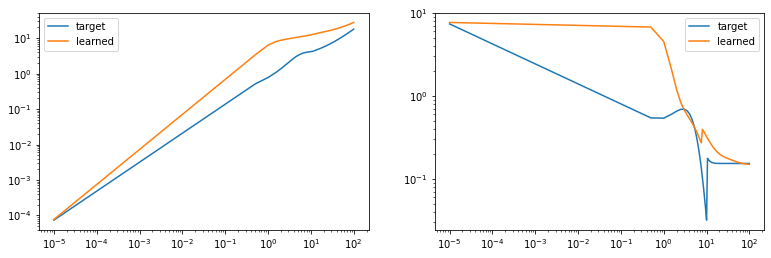

In [13]:
x_li = tf.linspace(1e-5, 100, num=200)
x_li = tf.cast(x_li, 'float64')

grad_real=[]
for x in x_li:
  with tf.GradientTape() as g:
    g.watch(x)
    y = R_real(x)
  grad_real.append(g.gradient(y, x))

y_real = [R_real(i) for i in x_li]

def performance_check(generator):
  plt.figure(figsize=(13,4))
  plt.subplot(121)
  # Real Generator Plot  
  plt.plot(tf.reshape(x_li,[-1]),tf.reshape(y_real,[-1]), label='target')
  # Plot fake R
  y = [R(i,generator.weights[0]) for i in x_li]
  plt.plot(tf.reshape(x_li,[-1]),tf.reshape(y,[-1]), label='learned')
  plt.yscale('log')
  plt.xscale('log')
  learned_r = integral(np.array([SSE(i) for i in x_li]),x_li)
  plt.title(f'log-log weighted L2 norm: {learned_r}') 
  plt.legend()

  plt.subplot(122)
  plt.plot(tf.reshape(x_li,[-1]),grad_real,label='target')

  grad=[]
  for x in x_li:
    with tf.GradientTape() as g:
      g.watch(x)
      y = R(x,generator.weights[0])
    grad.append(g.gradient(y, x))

  plt.plot(tf.reshape(x_li,[-1]),grad,label='learned')
  plt.title('log-log derivative comparsion')
  plt.yscale('log')
  plt.xscale('log')
  plt.legend()

  plt.show()

performance_check(generator)

## discriminator

In [14]:
discriminator = keras.Sequential(
    [
     Input(shape=(100,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [15]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [16]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)
generator_optimizer = tf.keras.optimizers.RMSprop(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

## Define trining_step

In [17]:
@tf.function
def training_step(generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      g_z = tf.math.log(generator(100)) / 10
      d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps(theta_real,100), (1,100))) / 10)
      d_x_fake = discriminator(g_z)

      discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
      # Adjusting Gradient of Discriminator
      gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
              
      generator_loss = generator_objective(d_x_fake)
      # Adjusting Gradient of Generator
      gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [18]:
def training(epoches):
  warnings.filterwarnings('ignore')
  for epoch in range(epoches + 1):
    mse.append(integral(np.array([SSE(i) for i in x_li]),x_li))
    training_step(generator, discriminator)
    if (epoch % 250) == 0: 
      print('epoch', epoch)
      performance_check(generator)

epoch 0
weighted L2 norm: 3.9307447503533028


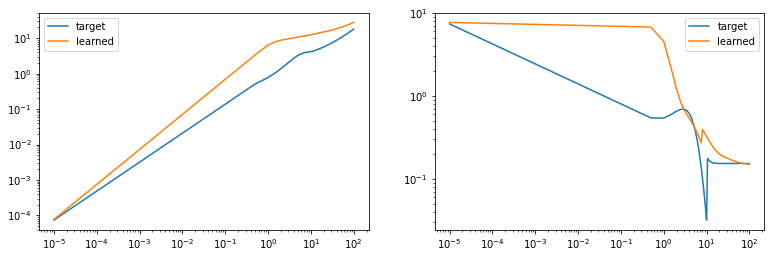

epoch 250
weighted L2 norm: 3.7615884300837257


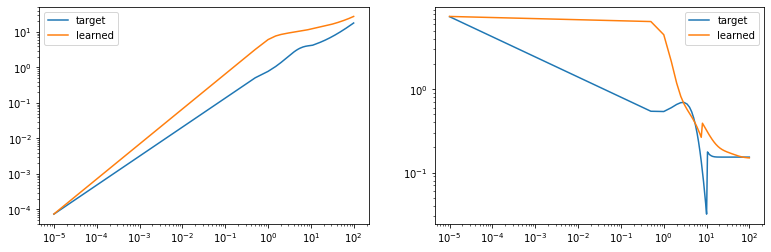

epoch 500
weighted L2 norm: 3.5863718963865634


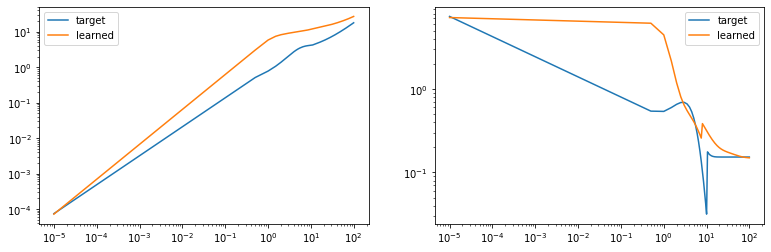

epoch 750
weighted L2 norm: 3.414068211046116


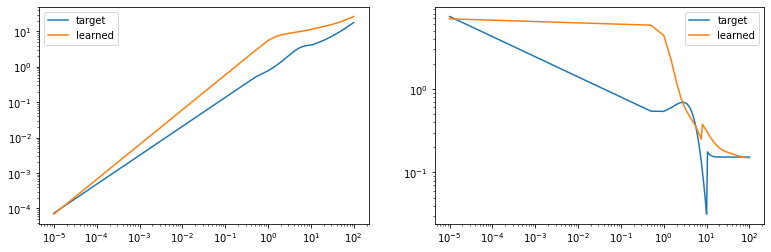

epoch 1000
weighted L2 norm: 3.2552885599530677


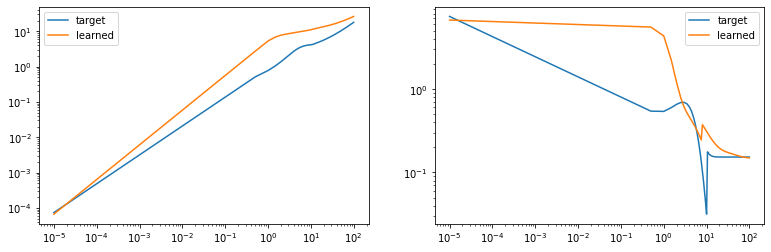

epoch 1250
weighted L2 norm: 3.0983212886648954


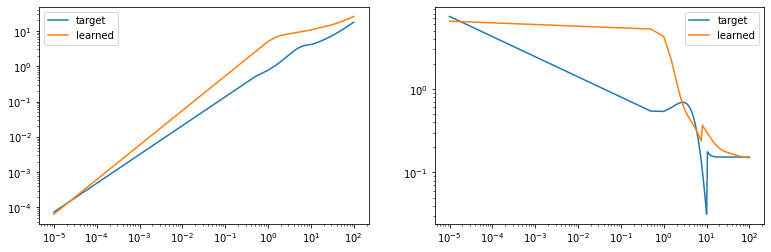

epoch 1500
weighted L2 norm: 2.9467829525067089


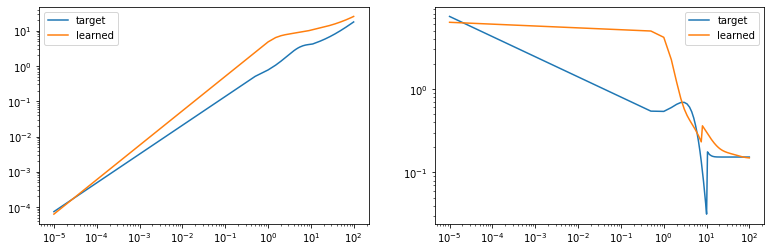

epoch 1750
weighted L2 norm: 2.8014512492159818


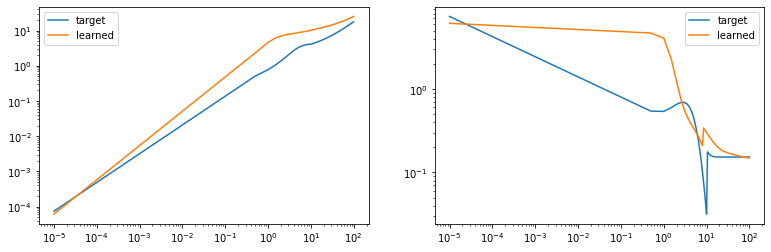

epoch 2000
weighted L2 norm: 2.6651931085756639


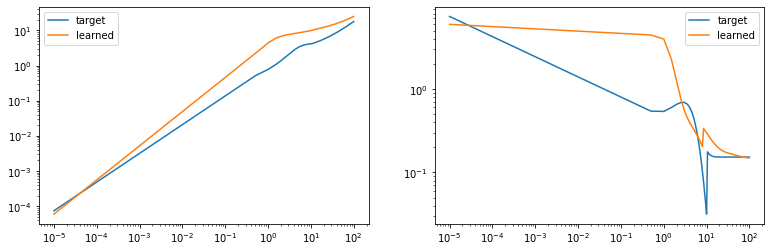

epoch 2250
weighted L2 norm: 2.5314537143190856


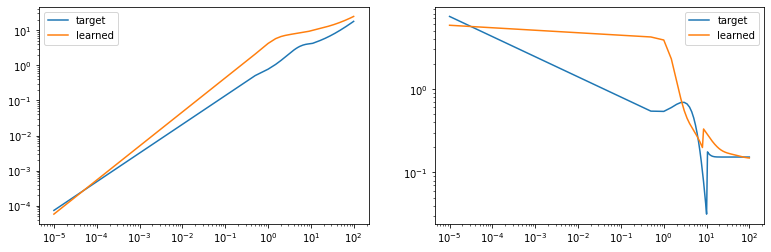

epoch 2500
weighted L2 norm: 2.4041517903637377


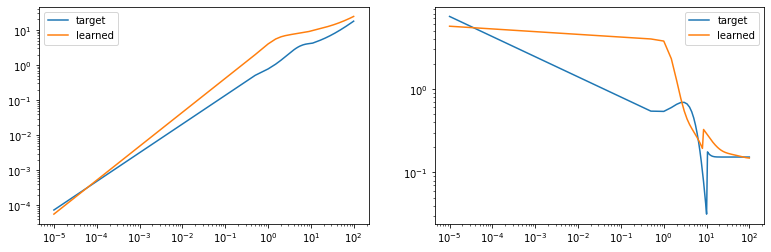

epoch 2750
weighted L2 norm: 2.2829163501128589


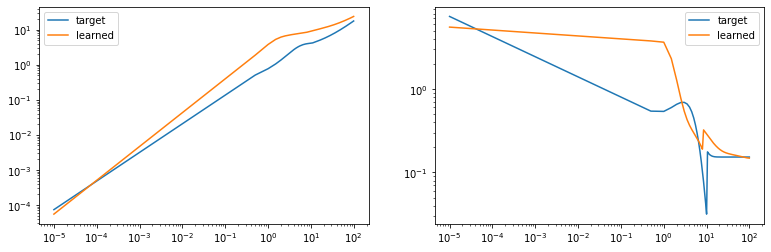

epoch 3000
weighted L2 norm: 2.1611828411428586


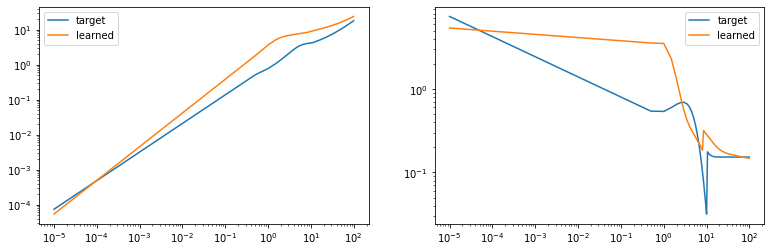

epoch 3250
weighted L2 norm: 2.0447668864887318


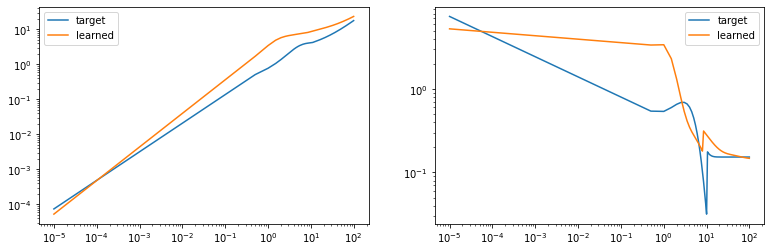

epoch 3500
weighted L2 norm: 1.9327960009750487


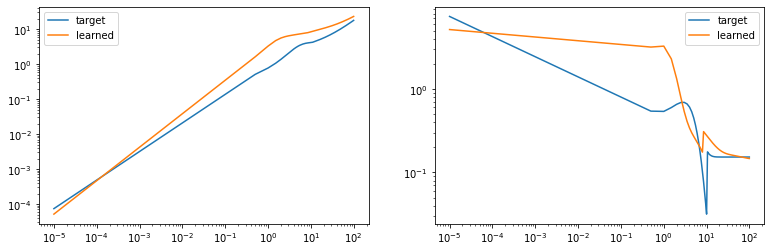

epoch 3750
weighted L2 norm: 1.827843233663162


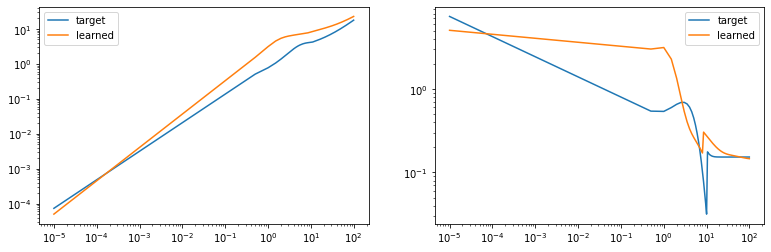

epoch 4000
weighted L2 norm: 1.7301833641900142


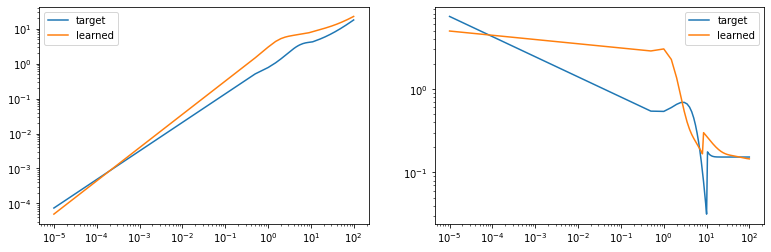

epoch 4250
weighted L2 norm: 1.6288541232858826


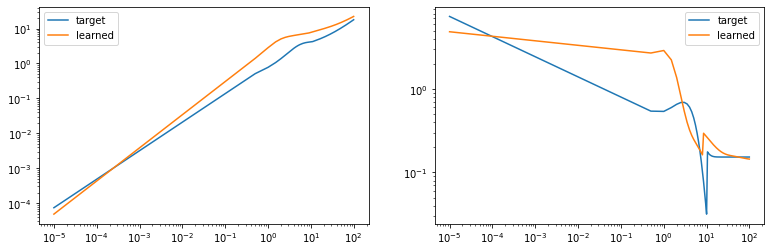

epoch 4500
weighted L2 norm: 1.5333856517950133


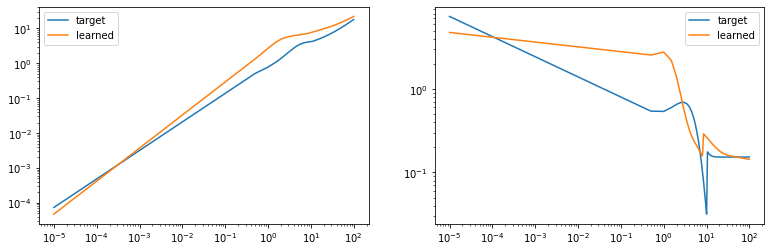

epoch 4750
weighted L2 norm: 1.4393151066376642


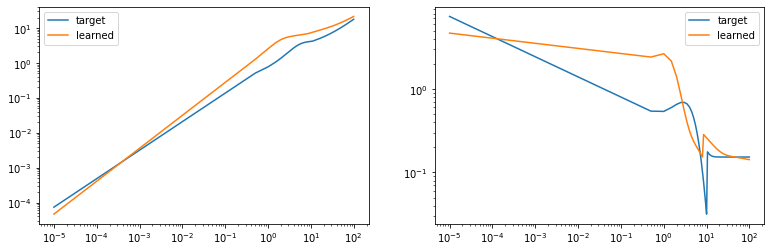

epoch 5000
weighted L2 norm: 1.3508094249751048


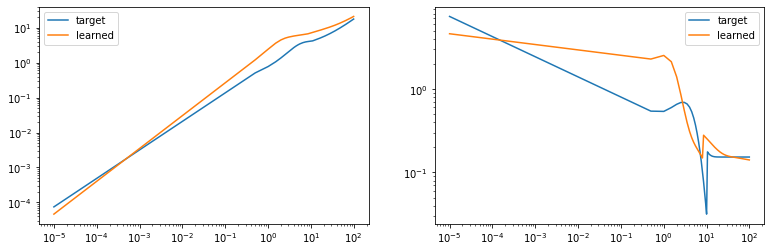

In [19]:
mse = []
EPOCHES = 5000
training(EPOCHES)

Text(0.5, 1.0, 'minimum weighted l2 norm is at epoch: 5000 and has value 1.351136')

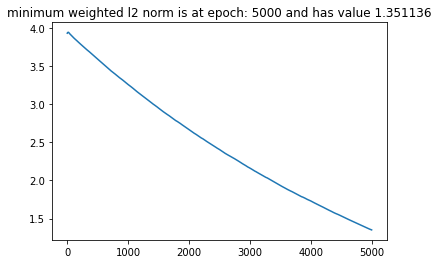

In [20]:
plt.plot(range(len(mse)),mse)
min_mse = min(mse)
min_pos = mse.index(min_mse)
plt.title(f"minimum weighted l2 norm is at epoch: {min_pos} and has value {min_mse:.6f}")